In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.base import clone
from xgboost import XGBClassifier

# 1. 데이터 로드
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# 2. 타겟 / 피처 분리
target_col = "diagnosed_diabetes"

X = train.drop(columns=[target_col])  # id 포함 상태
y = train[target_col].astype(int)     # float -> int(0/1)로 변환

# 3. 8:2 훈련/검증 세트 분할 (stratify로 클래스 비율 유지)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4. 수치형 / 범주형 컬럼 구분
# id, diagnosed_diabetes 제외하고 자동 구분
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
# id는 모델 학습에서 제외하는 것이 일반적
if "id" in numeric_features:
    numeric_features.remove("id")

categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# 5. 전처리 파이프라인 정의
# - 수치형: StandardScaler
# - 범주형: OneHotEncoder (미지 클래스 무시)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# 6. 로지스틱 회귀 파이프라인
log_reg_model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs"  # 기본 이며, 다수 특성에도 적합
)

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocess", clone(preprocessor)),
        ("model", log_reg_model),
    ]
)

# 7. XGBoost 파이프라인
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    tree_method="hist",        # GPU 없을 때도 빠른 편
    random_state=42,
    n_jobs=-1
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", clone(preprocessor)),
        ("model", xgb_model),
    ]
)

# =========================
# 8. 훈련 세트로 학습 + 검증 세트 평가
# =========================

print("\n====================")
print("1) Logistic Regression")
print("====================")
log_reg_pipeline.fit(X_train, y_train)

# 검증 예측 (클래스, 확률)
y_valid_pred_lr = log_reg_pipeline.predict(X_valid)
y_valid_proba_lr = log_reg_pipeline.predict_proba(X_valid)[:, 1]

print("Accuracy:", accuracy_score(y_valid, y_valid_pred_lr))
print("ROC-AUC:", roc_auc_score(y_valid, y_valid_proba_lr))
print("\n[Classification Report]\n", classification_report(y_valid, y_valid_pred_lr))
print("[Confusion Matrix]\n", confusion_matrix(y_valid, y_valid_pred_lr))

print("\n====================")
print("2) XGBoost")
print("====================")
xgb_pipeline.fit(X_train, y_train)

y_valid_pred_xgb = xgb_pipeline.predict(X_valid)
y_valid_proba_xgb = xgb_pipeline.predict_proba(X_valid)[:, 1]

print("Accuracy:", accuracy_score(y_valid, y_valid_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_valid, y_valid_proba_xgb))
print("\n[Classification Report]\n", classification_report(y_valid, y_valid_pred_xgb))
print("[Confusion Matrix]\n", confusion_matrix(y_valid, y_valid_pred_xgb))

# =========================
# 9. 전체 train으로 다시 학습 후 test 예측
# =========================

# (1) 로지스틱 전체 학습
log_reg_pipeline_full = Pipeline(
    steps=[
        ("preprocess", clone(preprocessor)),
        ("model", LogisticRegression(max_iter=1000, solver="lbfgs")),
    ]
)
log_reg_pipeline_full.fit(X, y)

# test 예측
test_pred_lr = log_reg_pipeline_full.predict(test)

submission_lr = sample_submission.copy()
submission_lr["diagnosed_diabetes"] = test_pred_lr.astype(int)

# (2) XGBoost 전체 학습
xgb_pipeline_full = Pipeline(
    steps=[
        ("preprocess", clone(preprocessor)),
        ("model", XGBClassifier(
            n_estimators=500,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            tree_method="hist",
            random_state=42,
            n_jobs=-1
        )),
    ]
)
xgb_pipeline_full.fit(X, y)

test_pred_xgb = xgb_pipeline_full.predict(test)

submission_xgb = sample_submission.copy()
submission_xgb["diagnosed_diabetes"] = test_pred_xgb.astype(int)

Numeric features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
Categorical features: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']

1) Logistic Regression
Accuracy: 0.6641142857142858
ROC-AUC: 0.6947675514013238

[Classification Report]
               precision    recall  f1-score   support

           0       0.60      0.33      0.43     52739
           1       0.68      0.86      0.76     87261

    accuracy                           0.66    140000
   macro avg       0.64      0.60      0.60    140000
weighted avg       0.65      0.66      0.64    140000

[Confusion Matrix]
 [[17646 35093]
 [11931 75330]]

2) XG

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from xgboost import XGBClassifier

# ============================================================================
# 1. 데이터 로드
# ============================================================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

target_col = "diagnosed_diabetes"

X = train.drop(columns=[target_col])  # id 포함
y = train[target_col].astype(int)     # 0/1 정수형으로 맞춤

# ============================================================================
# 2. Train / Validation 8:2 분할 (stratify로 비율 유지)
# ============================================================================
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ============================================================================
# 3. 수치형 / 범주형 컬럼 구분 (id는 학습에서 제외)
# ============================================================================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
if "id" in numeric_features:
    numeric_features.remove("id")

categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# ============================================================================
# 4. 전처리 파이프라인 (결측치 처리 + 스케일링/원핫)
# ============================================================================
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# ============================================================================
# 5. 개별 모델 정의 (로지스틱 회귀, XGBoost)
# ============================================================================
log_reg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs"
)

xgb_clf = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

# ============================================================================
# 6. VotingClassifier로 두 모델을 합친 앙상블 (soft voting)
#    - 두 모델의 확률 평균을 사용해 최종 예측
# ============================================================================
ensemble_clf = VotingClassifier(
    estimators=[
        ("lr", log_reg),
        ("xgb", xgb_clf),
    ],
    voting="soft",
    n_jobs=-1
)

# 전체 파이프라인: [전처리] → [앙상블 모델]
ensemble_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", ensemble_clf),
    ]
)

# ============================================================================
# 7. 8:2 훈련/검증 세트로 학습 및 성능 평가
# ============================================================================
print("\n====================")
print("Ensemble Model (Logistic + XGBoost, Soft Voting)")
print("====================")

ensemble_pipeline.fit(X_train, y_train)

y_valid_pred = ensemble_pipeline.predict(X_valid)
y_valid_proba = ensemble_pipeline.predict_proba(X_valid)[:, 1]

print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("ROC-AUC:", roc_auc_score(y_valid, y_valid_proba))
print("\n[Classification Report]\n", classification_report(y_valid, y_valid_pred))
print("[Confusion Matrix]\n", confusion_matrix(y_valid, y_valid_pred))

# ============================================================================
# 8. 전체 train 데이터로 다시 학습 후 test 예측
# ============================================================================
ensemble_pipeline_full = clone(ensemble_pipeline)
ensemble_pipeline_full.fit(X, y)

test_pred = ensemble_pipeline_full.predict(test)

# ============================================================================
# 9. sample_submission 형식에 맞춰 저장
# ============================================================================
submission = sample_submission.copy()
submission[target_col] = test_pred.astype(int)

Numeric features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
Categorical features: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']

Ensemble Model (Logistic + XGBoost, Soft Voting)
Accuracy: 0.6757285714285715
ROC-AUC: 0.7152282082369699

[Classification Report]
               precision    recall  f1-score   support

           0       0.62      0.37      0.46     52739
           1       0.69      0.86      0.77     87261

    accuracy                           0.68    140000
   macro avg       0.65      0.61      0.61    140000
weighted avg       0.66      0.68      0.65    140000

[Confusion Matrix]
 [[19424 333

In [3]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
df_encoded = train.copy()

spearman_results = []
for i in (X + y):
    rho, p = spearmanr(df_encoded[X], df_encoded[y])
    spearman_results.append({
        'variable': X,
        'rho': rho,
        'p_value': p
    })

spearman_df = pd.DataFrame(spearman_results)
spearman_df['abs_rho'] = spearman_df['rho'].abs()
spearman_df = spearman_df.sort_values('abs_rho', ascending=False)
print(spearman_df[['variable', 'rho', 'p_value']].to_string(index=False))

spearman_sorted = spearman_df.sort_values('rho')

plt.figure(figsize=(8, 6))
sns.barplot(
    data=spearman_sorted,
    x='rho',
    y='variable',
    palette='coolwarm'
)
plt.axvline(0, color='k', linestyle='-', linewidth=0.8)
plt.xlabel('Spearman rho')
plt.ylabel('Variable')
plt.title('스피어맨 상관계수 (연속형 vs diagnosed_diabetes)')
plt.tight_layout()
plt.show()

: 

연속형 변수 개수: 18
                          variable       rho       p_value
                               age  0.154630  0.000000e+00
      alcohol_consumption_per_week  0.004753  6.997353e-05
physical_activity_minutes_per_week -0.162939  0.000000e+00
                        diet_score -0.049691  0.000000e+00
               sleep_hours_per_day  0.003849  1.281592e-03
         screen_time_hours_per_day  0.018234  1.480901e-52
                               bmi  0.103140  0.000000e+00
                waist_to_hip_ratio  0.079840  0.000000e+00
                       systolic_bp  0.103735  0.000000e+00
                      diastolic_bp  0.034920 9.216973e-188
                        heart_rate  0.022616  7.198586e-80
                 cholesterol_total  0.083683  0.000000e+00
                   hdl_cholesterol -0.052727  0.000000e+00
                   ldl_cholesterol  0.099072  0.000000e+00
                     triglycerides  0.089697  0.000000e+00
           family_history_diabetes  0.2110

/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_9234/4252727228.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_9234/4252727228.py:51: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_9234/4252727228.py:51: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_9234/4252727228.py:51: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_9234/4252727228.py:51: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) D

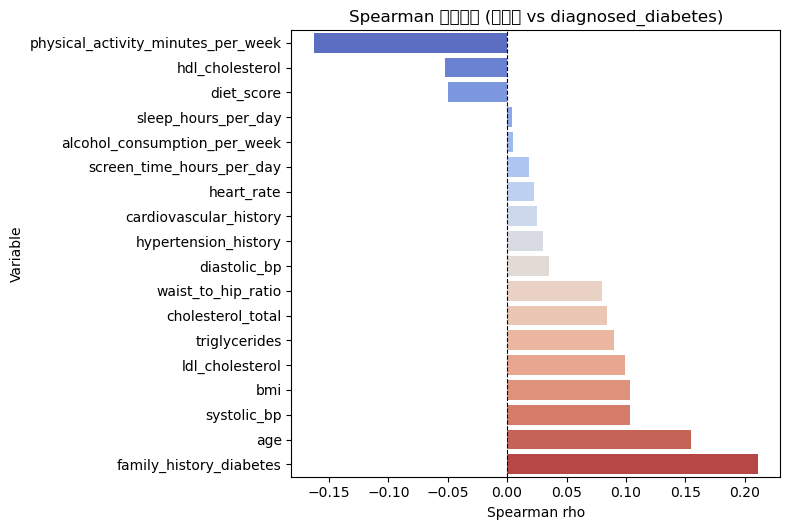

In [3]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

df_encoded = train.copy()

target_col = "diagnosed_diabetes"

# 1. 연속형 변수 선택 (id, target, 범주형 제외)
numeric_cols = df_encoded.select_dtypes(include=["int64", "float64"]).columns.tolist()
for col in [target_col, "id"]:
    if col in numeric_cols:
        numeric_cols.remove(col)

print("연속형 변수 개수:", len(numeric_cols))

# 2. 각 변수별 Spearman 계산
spearman_results = []
for col in numeric_cols:
    rho, p = spearmanr(
        df_encoded[col],
        df_encoded[target_col],
        nan_policy="omit"      # NaN이 있으면 무시
    )
    spearman_results.append({
        "variable": col,
        "rho": rho,
        "p_value": p,
    })

spearman_df = pd.DataFrame(spearman_results)
spearman_df["abs_rho"] = spearman_df["rho"].abs()

# rho 기준으로 정렬
spearman_sorted = spearman_df.sort_values("rho")

print(spearman_df[["variable", "rho", "p_value"]].to_string(index=False))

# 3. 시각화
plt.figure(figsize=(8, max(4, len(numeric_cols) * 0.3)))  # 변수 많으면 자동으로 높이 늘리기
sns.barplot(
    data=spearman_sorted,
    x="rho",
    y="variable",
    palette="coolwarm",
)
plt.axvline(0, color="k", linestyle="--", linewidth=0.8)
plt.xlabel("Spearman rho")
plt.ylabel("Variable")
plt.title("Spearman 상관계수 (연속형 vs diagnosed_diabetes)")
plt.tight_layout()
plt.show()


In [1]:
import numpy as np

existing_cols = [c for c in (X + y) if c in train.columns]
corr_df = train[existing_cols].copy()
corr_matrix = corr_df.corr(method='spearman')

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # 대각선 위쪽 가리기

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,        
    fmt='.2f',         
    cmap='coolwarm',   
    center=0,
    vmin=-1, vmax=1,   
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)
plt.title('Selected Variables Correlation Matrix (Spearman)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

NameError: name 'X' is not defined

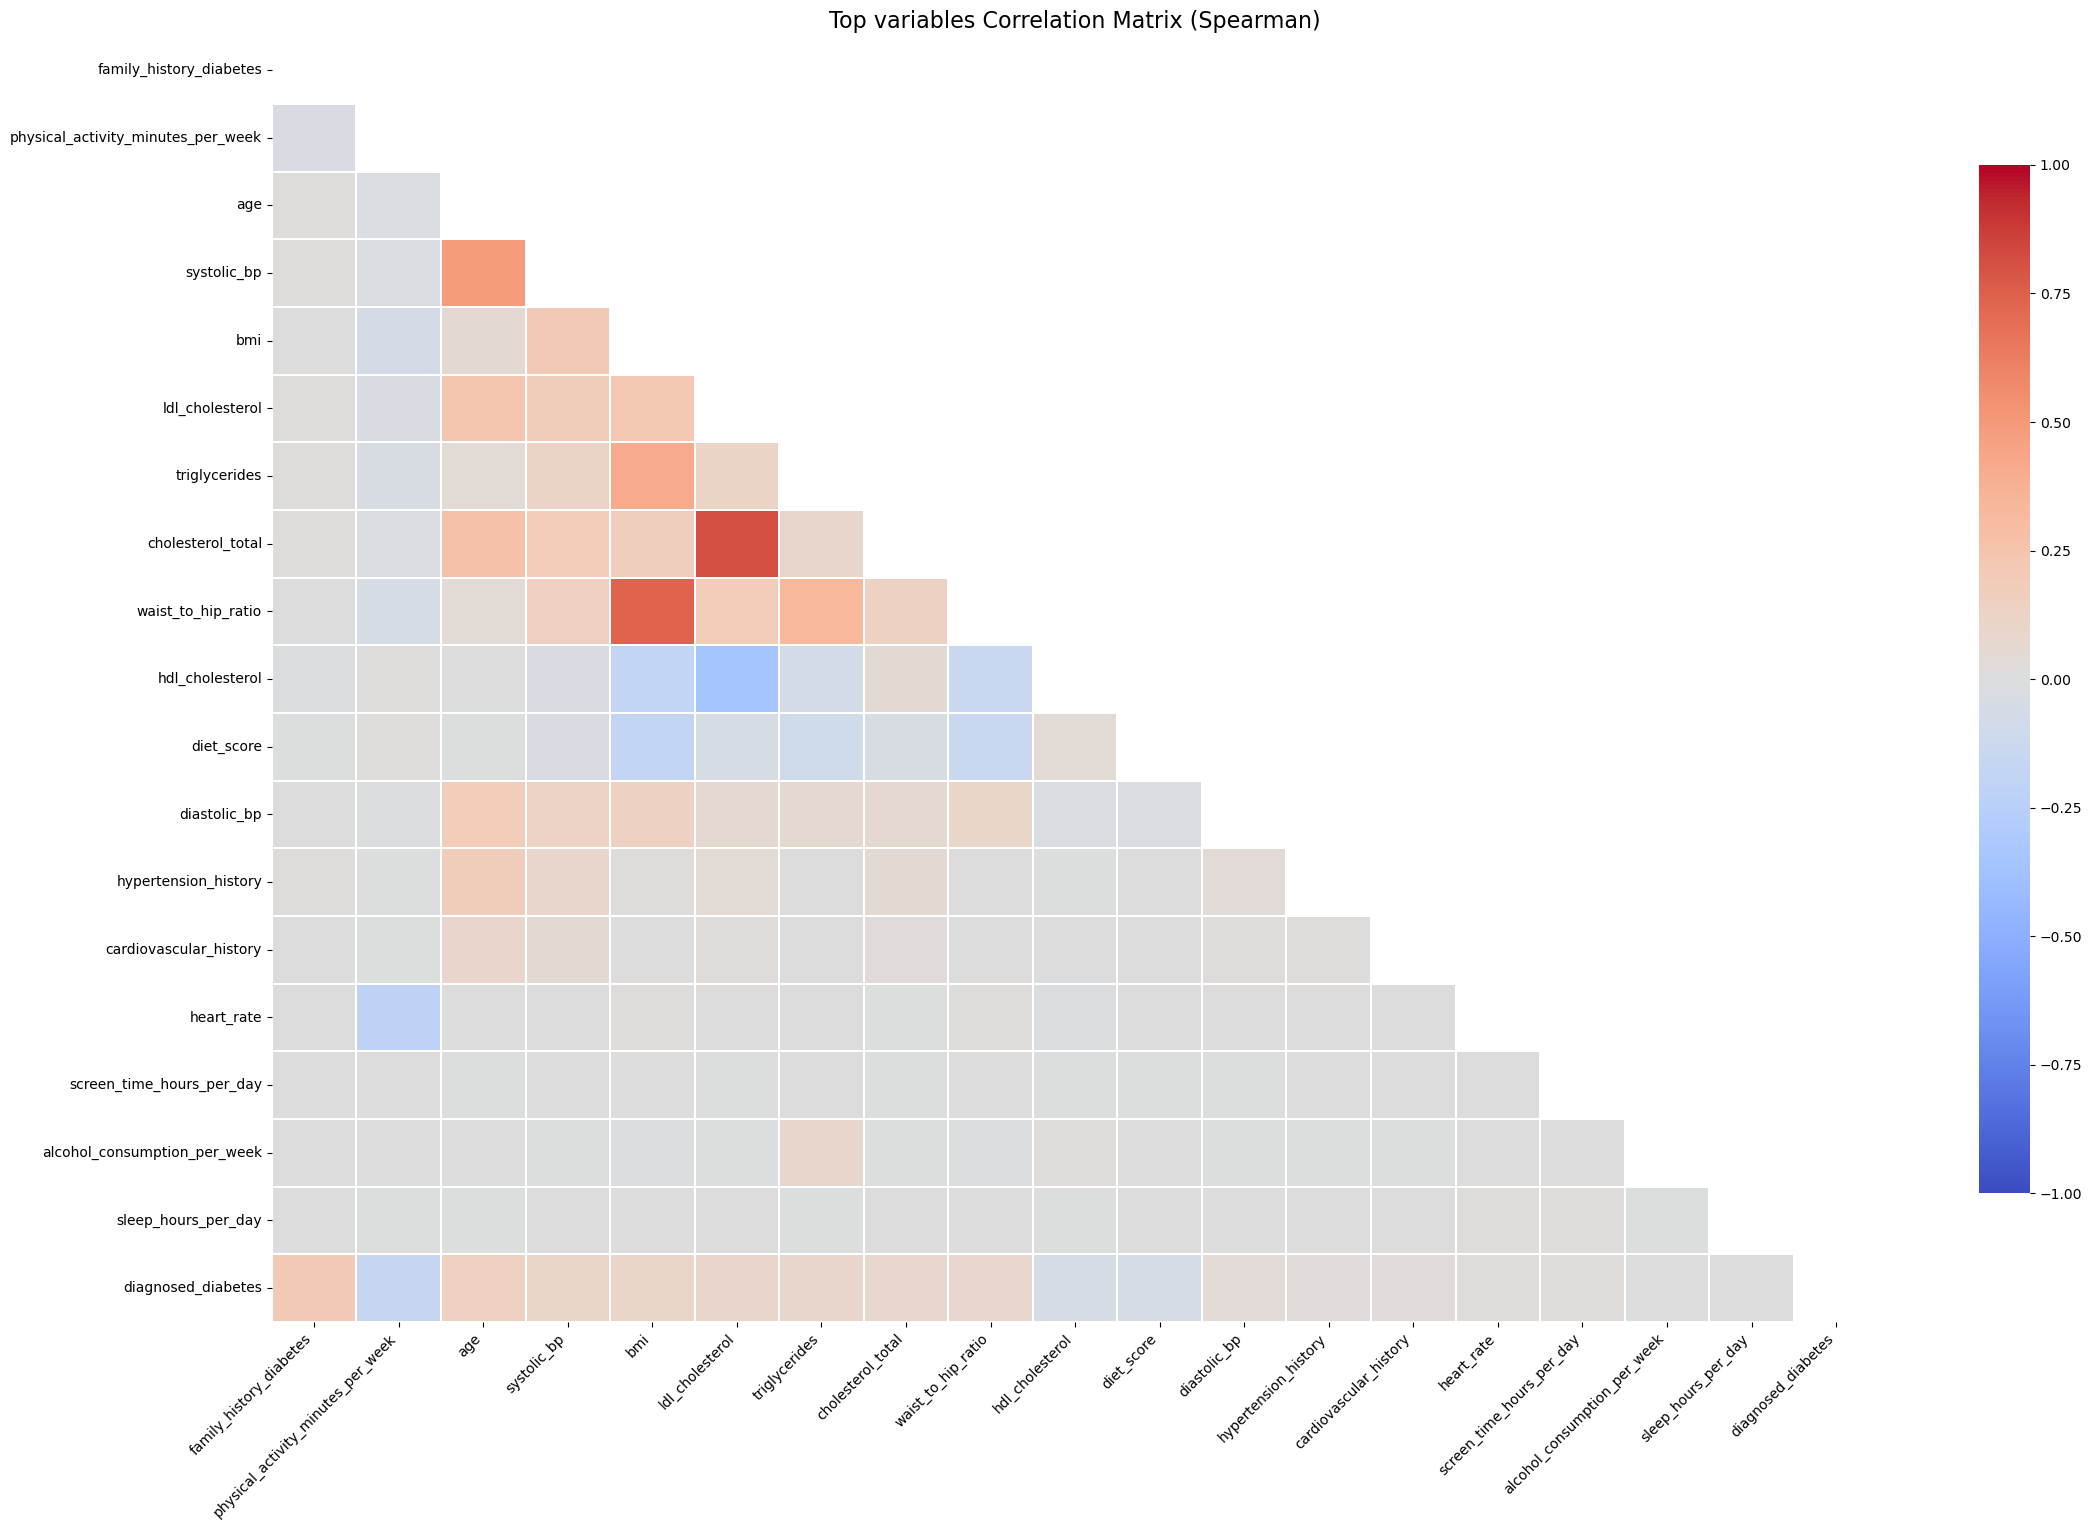

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

target_col = "diagnosed_diabetes"

# 1) spearman_df에서 |rho| 큰 변수 상위 k개 선택
top_k = 20  # 필요시 15, 30 등으로 조정
top_vars = (
    spearman_df.sort_values("abs_rho", ascending=False)
               .head(top_k)["variable"]
               .tolist()
)

# 2) 히트맵에 쓸 컬럼: 상위 변수 + 타겟
cols_for_corr = top_vars + [target_col]
cols_for_corr = [c for c in cols_for_corr if c in train.columns]

corr_df = train[cols_for_corr].copy()
corr_df = corr_df.astype(float)

# 3) Spearman 상관행렬 계산
corr_matrix = corr_df.corr(method="spearman")

# 4) 히트맵 그리기
n_vars = len(cols_for_corr)

plt.figure(
    figsize=(
        1.0 * n_vars + 4,   # 변수 수에 따라 자동으로 그림 크기 늘리기
        0.6 * n_vars + 4
    )
)

# 대각선 위쪽은 마스킹
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=(n_vars <= 15),   # 변수 15개 이하일 때만 숫자 표시, 그 이상이면 False
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8},
)

plt.title("Top variables Correlation Matrix (Spearman)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier

# =============================================================================
# 1. 데이터 로드
# =============================================================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

target_col = "diagnosed_diabetes"

X = train.drop(columns=[target_col])  # id 포함
y = train[target_col].astype(int)     # 0/1 정수형으로 맞춤

print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("\n[Target 분포]")
print(y.value_counts(normalize=True))

# =============================================================================
# 2. Train / Validation 8:2 분할 (stratify로 비율 유지)
# =============================================================================
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =============================================================================
# 3. 수치형 / 범주형 컬럼 구분 (id는 학습에서 제외)
# =============================================================================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
if "id" in numeric_features:
    numeric_features.remove("id")

categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# =============================================================================
# 4. 전처리 파이프라인 (결측치 처리 + 스케일링/원핫)
# =============================================================================
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# =============================================================================
# 5. 클래스 불균형 고려 (XGBoost용 scale_pos_weight)
# =============================================================================
pos = y_train.sum()
neg = len(y_train) - pos
if pos == 0:
    scale_pos_weight = 1.0
else:
    scale_pos_weight = neg / pos

print("\n[Class imbalance]")
print(f"positive (1): {pos}, negative (0): {neg}, scale_pos_weight ~ {scale_pos_weight:.3f}")

# =============================================================================
# 6. 로지스틱 회귀 파이프라인 (Baseline + 앙상블용)
# =============================================================================
log_reg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight="balanced"   # 클래스 불균형 자동 보정
)

lr_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", log_reg),
    ]
)

# =============================================================================
# 7. XGBoost 파이프라인 + RandomizedSearchCV로 하이퍼파라미터 튜닝
# =============================================================================
xgb_base = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", xgb_base),
    ]
)

param_distributions = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "model__min_child_weight": [1, 3, 5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=20,                 # 필요 시 늘려도 됨
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
)

print("\n====================")
print("XGBoost RandomizedSearchCV (train 80% 내부에서 CV)")
print("====================")
xgb_search.fit(X_train, y_train)

print("\n[XGBoost best params]")
print(xgb_search.best_params_)
print("Best CV ROC-AUC:", xgb_search.best_score_)

best_xgb_pipeline = xgb_search.best_estimator_

# =============================================================================
# 8. 홀드아웃 검증 세트에서 각 모델 성능 비교
# =============================================================================
def eval_model(name, clf, X_tr, y_tr, X_va, y_va):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_va)
    y_proba = clf.predict_proba(X_va)[:, 1]

    print(f"\n====================\n{name}\n====================")
    print("Accuracy          :", accuracy_score(y_va, y_pred))
    print("Balanced Accuracy :", balanced_accuracy_score(y_va, y_pred))
    print("ROC-AUC           :", roc_auc_score(y_va, y_proba))
    print("\n[Classification Report]\n", classification_report(y_va, y_pred))
    print("[Confusion Matrix]\n", confusion_matrix(y_va, y_pred))

# 로지스틱 단독
eval_model("Logistic Regression (balanced)", lr_pipeline, X_train, y_train, X_valid, y_valid)

# 튜닝된 XGBoost 단독
eval_model("Tuned XGBoost", best_xgb_pipeline, X_train, y_train, X_valid, y_valid)

# =============================================================================
# 9. 로지스틱 + 튜닝 XGBoost 앙상블 (Soft Voting)
#    - 두 estimator 모두 Pipeline 형태임
# =============================================================================
ensemble_clf = VotingClassifier(
    estimators=[
        ("lr", lr_pipeline),
        ("xgb", best_xgb_pipeline),
    ],
    voting="soft",
    weights=[1, 2],   # XGBoost에 조금 더 가중치 (원하면 조정 가능)
    n_jobs=-1,
)

# 홀드아웃 검증 성능
eval_model("Ensemble (Logistic + Tuned XGBoost, soft voting)", ensemble_clf, X_train, y_train, X_valid, y_valid)

# =============================================================================
# 10. 최종 모델: 전체 train(X, y)로 앙상블 재학습 후 test 예측
# =============================================================================
ensemble_full = VotingClassifier(
    estimators=[
        ("lr", lr_pipeline),
        ("xgb", best_xgb_pipeline),
    ],
    voting="soft",
    weights=[1, 2],
    n_jobs=-1,
)

ensemble_full.fit(X, y)

test_pred = ensemble_full.predict(test)

submission = sample_submission.copy()
submission[target_col] = test_pred.astype(int)


Train shape: (700000, 26)
Test shape : (300000, 25)

[Target 분포]
diagnosed_diabetes
1    0.623296
0    0.376704
Name: proportion, dtype: float64

Numeric features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
Categorical features: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']

[Class imbalance]
positive (1): 349046, negative (0): 210954, scale_pos_weight ~ 0.604

XGBoost RandomizedSearchCV (train 80% 내부에서 CV)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/machanho/miniconda3/envs/ai-study/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



[XGBoost best params]
{'model__subsample': 0.9, 'model__n_estimators': 600, 'model__min_child_weight': 5, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
Best CV ROC-AUC: 0.7257697072936342

Logistic Regression (balanced)
Accuracy          : 0.62725
Balanced Accuracy : 0.6374874305443302
ROC-AUC           : 0.6948496290304914

[Classification Report]
               precision    recall  f1-score   support

           0       0.50      0.68      0.58     52739
           1       0.75      0.60      0.67     87261

    accuracy                           0.63    140000
   macro avg       0.63      0.64      0.62    140000
weighted avg       0.66      0.63      0.63    140000

[Confusion Matrix]
 [[35810 16929]
 [35256 52005]]

Tuned XGBoost
Accuracy          : 0.6567071428571428
Balanced Accuracy : 0.6643508041155604
ROC-AUC           : 0.7256668461817927

[Classification Report]
               precision    recall  f1-score   support

           0      

In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier


# =============================================================================
# 1. 데이터 로드
# =============================================================================
train = pd.read_csv("train.csv")

target_col = "diagnosed_diabetes"

X_raw = train.drop(columns=[target_col])
y = train[target_col].astype(int)

print("Train shape:", train.shape)
print("[Target 분포]\n", y.value_counts(normalize=True))


# =============================================================================
# 2. Feature Engineering 함수 정의
# =============================================================================
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # 안전한 분모를 위한 epsilon
    eps = 1e-3
    
    # --- 혈압 관련 ---
    df["pulse_pressure"] = df["systolic_bp"] - df["diastolic_bp"]
    df["mean_arterial_pressure"] = df["diastolic_bp"] + df["pulse_pressure"] / 3.0
    
    # --- 지질 관련 ---
    df["non_hdl_cholesterol"] = df["cholesterol_total"] - df["hdl_cholesterol"]
    df["chol_hdl_ratio"] = df["cholesterol_total"] / (df["hdl_cholesterol"] + eps)
    df["tg_hdl_ratio"] = df["triglycerides"] / (df["hdl_cholesterol"] + eps)
    df["log_triglycerides"] = np.log(df["triglycerides"] + 1.0)
    df["log_tg_hdl_ratio"] = np.log(df["tg_hdl_ratio"] + 1.0)
    
    # --- 비만 관련 ---
    df["bmi_over_25"] = (df["bmi"] >= 25).astype(int)
    df["bmi_obese_30"] = (df["bmi"] >= 30).astype(int)
    
    # --- 연령 구간 ---
    df["age_group"] = pd.cut(
        df["age"],
        bins=[0, 39, 49, 59, 200],
        labels=["<40", "40-49", "50-59", "60+"],
        right=True,
    )
    
    # --- 수면/스크린/활동 ---
    df["sleep_deficit"] = np.clip(7.0 - df["sleep_hours_per_day"], 0, None)
    df["sleep_overshoot"] = np.clip(df["sleep_hours_per_day"] - 9.0, 0, None)
    
    df["screen_high_6h"] = (df["screen_time_hours_per_day"] >= 6).astype(int)
    
    df["activity_hours_week"] = df["physical_activity_minutes_per_week"] / 60.0
    df["activity_high_2h_day"] = (
        df["physical_activity_minutes_per_week"] >= 120
    ).astype(int)
    
    df["lifestyle_score_simple"] = (
        (df["diet_score"] / 10.0)
        + (df["activity_hours_week"] / 7.0)
        - (df["screen_time_hours_per_day"] / 8.0)
        - (df["sleep_deficit"] / 3.0)
    )
    
    # --- 상호작용 ---
    df["bmi_x_activity"] = df["bmi"] * df["activity_hours_week"]
    df["age_x_bmi"] = df["age"] * df["bmi"]
    df["sbp_x_bmi"] = df["systolic_bp"] * df["bmi"]
    
    return df


# =============================================================================
# 3. 동일한 split을 위해 index 기반으로 train/valid 분리
# =============================================================================
idx = np.arange(len(X_raw))
idx_train, idx_valid, y_train, y_valid = train_test_split(
    idx,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

def split_by_index(X: pd.DataFrame, idx_train, idx_valid):
    return X.iloc[idx_train].reset_index(drop=True), X.iloc[idx_valid].reset_index(drop=True)

# Baseline용 feature / FE용 feature 준비
X_base = X_raw.copy()
X_fe = add_features(X_raw)

X_train_base, X_valid_base = split_by_index(X_base, idx_train, idx_valid)
X_train_fe, X_valid_fe = split_by_index(X_fe, idx_train, idx_valid)

y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)


# =============================================================================
# 4. 공통으로 사용할 "모델 빌더 + 평가 함수"
# =============================================================================
def build_ensemble_pipeline(X_sample: pd.DataFrame, y_sample: pd.Series) -> Pipeline:
    """
    주어진 feature 집합(X_sample)에 맞게
    - 수치형 / 범주형 컬럼 자동 분리
    - 전처리 (impute + scale / one-hot)
    - 로지스틱 + XGBoost soft voting 앙상블
    으로 구성된 Pipeline을 반환
    """
    # 수치형 / 범주형 컬럼 구분
    numeric_features = X_sample.select_dtypes(include=["int64", "float64"]).columns.tolist()
    if "id" in numeric_features:
        numeric_features.remove("id")
    
    categorical_features = X_sample.select_dtypes(include=["object", "category"]).columns.tolist()
    
    # 전처리
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )
    
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    
    # 클래스 불균형 보정 (XGBoost용)
    pos = y_sample.sum()
    neg = len(y_sample) - pos
    scale_pos_weight = (neg / pos) if pos > 0 else 1.0
    
    # 개별 모델
    log_reg = LogisticRegression(
        max_iter=1000,
        solver="lbfgs",
        class_weight="balanced",
    )
    
    xgb_clf = XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
    )
    
    ensemble = VotingClassifier(
        estimators=[
            ("lr", log_reg),
            ("xgb", xgb_clf),
        ],
        voting="soft",
        weights=[1, 2],   # XGBoost에 약간 더 가중치
        n_jobs=-1,
    )
    
    model = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", ensemble),
        ]
    )
    
    return model


def evaluate_model(name: str, model: Pipeline, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)
    y_proba = model.predict_proba(X_va)[:, 1]
    
    print(f"\n====================\n{name}\n====================")
    print("Accuracy          :", accuracy_score(y_va, y_pred))
    print("Balanced Accuracy :", balanced_accuracy_score(y_va, y_pred))
    print("ROC-AUC           :", roc_auc_score(y_va, y_proba))
    print("\n[Classification Report]\n", classification_report(y_va, y_pred))
    print("[Confusion Matrix]\n", confusion_matrix(y_va, y_pred))


# =============================================================================
# 5. Baseline 모델 평가 (Feature engineering 없이)
# =============================================================================
baseline_model = build_ensemble_pipeline(X_train_base, y_train)
evaluate_model("Baseline (원본 feature만 사용)", baseline_model, X_train_base, y_train, X_valid_base, y_valid)

# =============================================================================
# 6. Feature Engineering 모델 평가 (새 feature 포함)
# =============================================================================
fe_model = build_ensemble_pipeline(X_train_fe, y_train)
evaluate_model("Feature Engineering 적용 모델", fe_model, X_train_fe, y_train, X_valid_fe, y_valid)


Train shape: (700000, 26)
[Target 분포]
 diagnosed_diabetes
1    0.623296
0    0.376704
Name: proportion, dtype: float64

Baseline (원본 feature만 사용)
Accuracy          : 0.6436
Balanced Accuracy : 0.6549165758547384
ROC-AUC           : 0.7148580742567405

[Classification Report]
               precision    recall  f1-score   support

           0       0.52      0.70      0.60     52739
           1       0.77      0.61      0.68     87261

    accuracy                           0.64    140000
   macro avg       0.65      0.65      0.64    140000
weighted avg       0.68      0.64      0.65    140000

[Confusion Matrix]
 [[36960 15779]
 [34117 53144]]

Feature Engineering 적용 모델
Accuracy          : 0.6427357142857143
Balanced Accuracy : 0.6540732249882248
ROC-AUC           : 0.7143744156286826

[Classification Report]
               precision    recall  f1-score   support

           0       0.52      0.70      0.60     52739
           1       0.77      0.61      0.68     87261

    accurac